# Coordinates in the SunPy Ecosystem

*(Parts of this notebook have been directly adapted from [this notebook](https://github.com/sunpy/aas-2021-workshop/blob/main/02-Introduction-to-Coordinates.ipynb) presented by Dr. Albert Y. Shih at the 2021 AAS SPD SunPy Workshop)*

In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.time
from astropy.wcs import WCS
from astropy.visualization import time_support

from sunpy.net import Fido, attrs as a
from sunpy.coordinates import HeliographicStonyhurst, Helioprojective, get_earth
import sunpy.map
import sunpy.timeseries
import sunpy.sun

from aiapy.calibrate import degradation, correct_degradation

In this notebook, we will give a short introduction to the use of coordinates in `sunpy` and then demonstrate how the coordinates framework can be used to make full use of our observations from all three observatories.

## Introduction to `sunpy.coordinates`

`sunpy` extends the `astropy.coordinates` framework by adding additional solar-specific coordinate frames and the accompanying transformations between them.

![](images/coordinates.svg)

This transformation graph reveals some of the underlying complexity to the coordinates framework, but for normal situations, a user does not need to be aware what transformations are necessary.  Everything is taken care of "under the hood"!  This includes transformations between systems defined in SunPy (red box) and systems defined in Astropy (blue box).

### A solar coordinate frame

An example of a solar-specific coordinate system is the Stonyhurst heliographic (HGS) coordinate system. The HGS system is defined with the following Cartesian axes:

* The origin is the center of the Sun
* The Z-axis (+90 degrees latitude) is aligned with the Sun’s north pole.
* The X-axis (0 degrees longitude and 0 degrees latitude) is perpendicular to the Z-axis such that the XZ-plane contains the Sun-Earth line.  That is, Earth is at 0 degrees longitude (but usually not at 0 degrees latitude).
* The Y-axis (+90 degrees longitude and 0 degrees latitude) is perpendicular to both the X-axis and the Z-axis in a right-handed fashion.

Then, the coordinate frame is the realization of this definition at a particular time, which defines the position/orientation of the Sun and the position of the Earth.

Let's create a frame for Stonyhurst heliographic coordinates using SunPy's [`HeliographicStonyhurst` class](https://docs.sunpy.org/en/stable/api/sunpy.coordinates.frames.HeliographicStonyhurst.html):

In [2]:
time = '2022-03-28 11:00'
hgs_frame = HeliographicStonyhurst(obstime=time)
hgs_frame

<HeliographicStonyhurst Frame (obstime=2022-03-28T11:00:00.000, rsun=695700.0 km)>

### Coordinates and different representations

A **coordinate** combines position data with a `SkyCoord`.  This position data can have different **representations**, e.g., spherical components or Cartesian components.

In [3]:
hgs_coord = SkyCoord(10*u.deg, 20*u.deg, 1*u.AU, frame=hgs_frame)  # longitude, latitude, and distance from the origin
hgs_coord

<SkyCoord (HeliographicStonyhurst: obstime=2022-03-28T11:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (10., 20., 1.)>

In [4]:
print(f"""Longitude: {hgs_coord.lon}
Latitude: {hgs_coord.lat}
Distance from Sun center: {hgs_coord.radius}""")

Longitude: 10.0 deg
Latitude: 20.0 deg
Distance from Sun center: 1.0 AU


Stonyhurst heliographic coordinates with Cartesian components is also known as Heliocentric Earth Equatorial (HEEQ).

In [5]:
hgs_coord_xyz = SkyCoord(hgs_coord, representation_type='cartesian')
hgs_coord_xyz

<SkyCoord (HeliographicStonyhurst: obstime=2022-03-28T11:00:00.000, rsun=695700.0 km): (x, y, z) in AU
    (0.92541658, 0.16317591, 0.34202014)>

<div class="alert alert-block alert-warning">
    <h3><u>EXERCISE:</u> <br><br>How would you access the individual components of the Cartesian HGS coordinate?</h3>
</div>

In [6]:
# INSTRUCTOR BLOCK
print(f"""X: {hgs_coord_xyz.x}
Y: {hgs_coord_xyz.y}
Z: {hgs_coord_xyz.z}""")

X: 0.9254165783983234 AU
Y: 0.16317591116653482 AU
Z: 0.3420201433256687 AU


### Observer-based frames

A number of coordinate frames are **observer-based**, which means that the position of the observer is fundamental to the definition of the coordinate frame.  For example, helioprojective Cartesian coordinates are aligned such that one axis is aligned with the Sun-observer line.  Let's use the above `HeliographicStonyhurst` coordinate as the observer for a [`Helioprojective` frame](https://docs.sunpy.org/en/stable/api/sunpy.coordinates.frames.Helioprojective.html), here for 2D helioprojective coordinates (theta_x, theta_y) = (123 arcsec, 456 arcsec).

In [7]:
hpc_frame = Helioprojective(obstime=time, observer=hgs_coord)
SkyCoord(123*u.arcsec, 456*u.arcsec, frame=hpc_frame)

<SkyCoord (Helioprojective: obstime=2022-03-28T11:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-28T11:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (10., 20., 1.)>): (Tx, Ty) in arcsec
    (123., 456.)>

Recall that all of our images from the previous were defined in a Helioprojective frame such that the resulting center and corner coordinates were expressed in Helioprojective coordinates.

## Applications

### Plotting Flare Position

Let's use our newfound knowledge of coordinates to plot the positions of the detected flares around the time we know that the CME initiated.
To find the metadata for any flares that were detected at this time, we'll again use `Fido` to query the Heliophysics Event Knowledgebase (HEK).
This can be done by using the HEK client specific attributes `a.hek.attrs`.

In [8]:
cme_start = "2022-03-28 11:00"
cme_end = "2022-03-28 12:00"

We'll choose only flare events who have a GOES class above C2.5

In [9]:
hek_result = Fido.search(a.Time(cme_start, cme_end),
                         a.hek.EventType('FL'),
                         a.hek.FL.GOESCls > 'C2.5')

The HEK keeps track of a lot of information for each event in the database.
Let's filter this down to the start, end, and peak times of the flare, the GOES classification, and the coordinates of the flare on the disk.

In [10]:
flare_table = hek_result['hek'][
    'event_starttime',
    'event_peaktime',
    'event_endtime',
    'fl_goescls',
    'hpc_x',
    'hpc_y',
]

In [11]:
flare_table

event_starttime,event_peaktime,event_endtime,fl_goescls,hpc_x,hpc_y
Time,Time,Time,str4,float64,float64
2022-03-28 10:58:00.000,2022-03-28 11:29:00.000,2022-03-28 11:45:00.000,M4.0,0.0,113.204178
2022-03-28 10:58:00.000,2022-03-28 11:29:00.000,2022-03-28 11:45:00.000,M4.0,65.315424,341.386302


Additionally, let's load back in our GOES XRS timeseries over the entire time interval of interest as well as our AIA and EUVI maps.

In [14]:
goes_files = sorted(glob.glob('data/XRS/*.nc'))
ts = sunpy.timeseries.TimeSeries(goes_files)

In [15]:
aia_files = sorted(glob.glob('data/AIA/*.fits'))
stereo_files = sorted(glob.glob('data/SECCHI/*.fts'))
m_aia, m_stereo = sunpy.map.Map(aia_files[6],
                                       stereo_files[6])

First, let's plot the times of the flares on top of our untruncated timeseries.
We'll indicate each flare with a shaded blue region and our original time interval of interest that we used to query our imaging observations with orange.

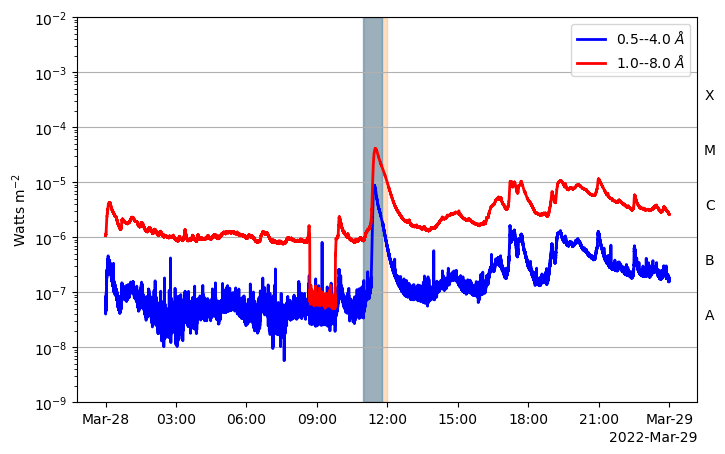

In [16]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ts.plot(axes=ax)
ax.axvspan(cme_start, cme_end, alpha=0.25, color='C1')
for fl in flare_table:
    ax.axvspan(fl['event_starttime'].iso, fl['event_endtime'].iso,
               color='C0', alpha=0.25)

We see from the plot and manually examining the table above that two of the flares from the HEK occurred near the beginning of the CME.

To further understand whether these flares in the HEK database correspond to the observed CME, we can plot the positions of the flares that occurred near the start of our observing interval on our AIA image.

We'll do this by first constructing a coordinate for each flare using the HPC positions returned by the HEK.
Though not explicitly stated here, these coordinates are computed assuming an Earth-based observer at the start time of the event.

We can get a `SkyCoord` denoting the position of Earth using the `sunpy.coordinates.get_earth` function.

In [17]:
flare_coords = []
for fl in flare_table:
    earth = get_earth(fl['event_starttime'])
    hpc_frame = Helioprojective(obstime=fl['event_starttime'], observer=earth)
    hpc_coord = SkyCoord(Tx=fl['hpc_x']*u.arcsec, Ty=fl['hpc_y']*u.arcsec, frame=hpc_frame)
    flare_coords.append(hpc_coord)

Finally, let's overplot these coordinates on our AIA and EUVI images.
The `plot_coord` command takes in a `SkyCoord` object and automatically transforms the coordinate to the coordinate system defined by the WCS on that axis.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


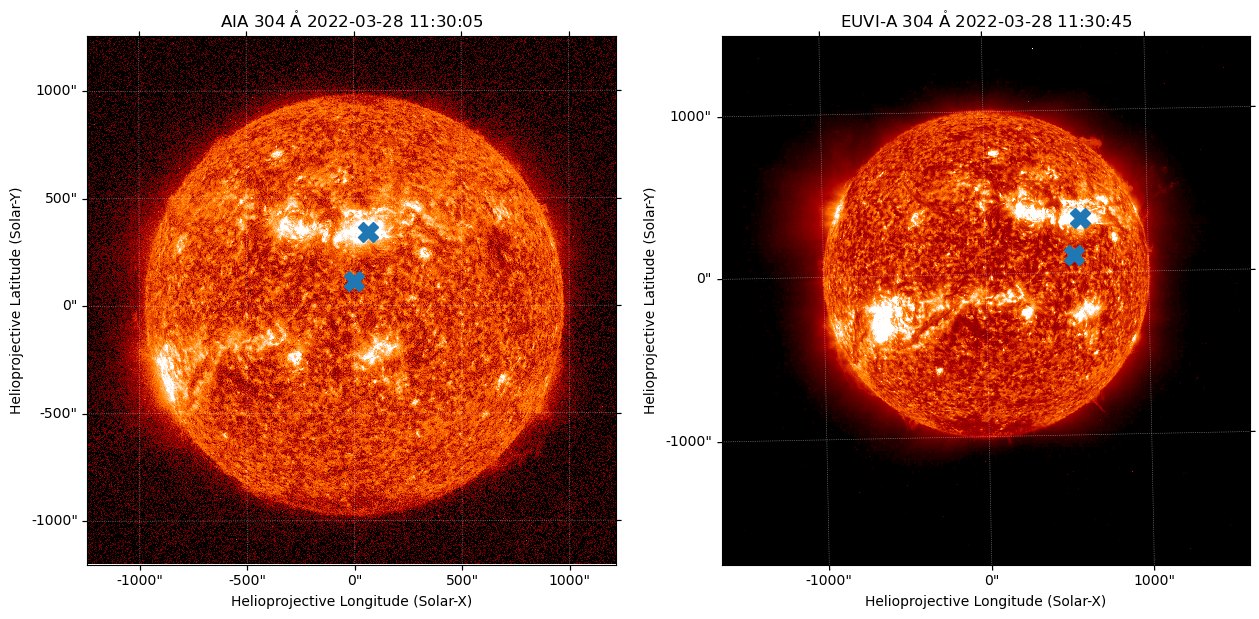

In [18]:
fig = plt.figure(figsize=(15,7.5))
for i,m in enumerate([m_aia, m_stereo]):
    ax = fig.add_subplot(1,2,i+1, projection=m)
    m.plot(axes=ax,clip_interval=(25,99.5)*u.percent)
    for fl in flare_coords:
        ax.plot_coord(fl, marker='X', color='C0', markersize=15)

We find that one of the flares queried from the HEK coincides with our observed CME while the other is offset to the south.

### Combining Data from AIA, EUI, and EUVI

Finally, let's combine the data from all three of these observatories into a single image by *reprojecting* them into a common coordinate system.
The approach we will follow here is adapted from [this example](https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_aia_euvi_mosaic.html#sphx-glr-generated-gallery-map-transformations-reprojection-aia-euvi-mosaic-py) from our gallery in the `sunpy` documentation.

#### Preparing the Image Data

When combining these images all three need to assume the same radius of
the Sun for the data. The AIA images specify a slightly different value
than the IAU 2015 constant. To avoid coordinate transformation issues we
reset this here.



In [20]:
m_stereo.meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)
m_aia.meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)

Before combining all of our images, we need to make a few adjustments to some of the maps.

Neither the AIA nor the EUVI map have been normalized to the exposure time so we do that here such that all images have the same units.

In [23]:
m_aia /= m_aia.exposure_time
m_stereo /= m_stereo.exposure_time

Additionally, the 304 channel of AIA has experienced significant degradation since the launch of the satellite in 2010.
The SunPy affiliated package `aiapy` includes a model of this degradation as a function of time.
To illustrate this, we can plot the degradation of the 304 channel (and 171 channel for reference) as a function of time.

In [24]:
time_0 = astropy.time.Time('2010-03-25T00:00:00', scale='utc')
now = astropy.time.Time.now()
time = time_0 + np.arange(0, (now - time_0).to(u.day).value, 7) * u.day

In [25]:
deg_171 = degradation(171*u.angstrom, time)
deg_304 = degradation(304*u.angstrom, time)

/srv/conda/envs/notebook/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/srv/conda/envs/notebook/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/srv/conda/envs/notebook/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/srv/conda/envs/notebook/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/srv/conda/envs/notebook/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubio

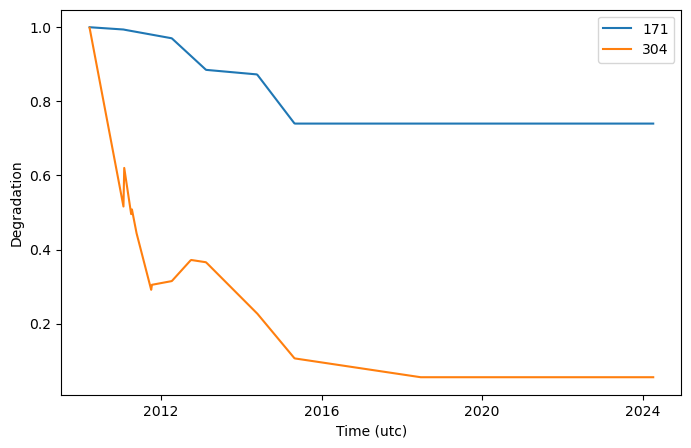

In [26]:
plt.figure(figsize=(8,5))
with time_support(format='jyear'):
    plt.plot(time, deg_171, label='171')
    plt.plot(time, deg_304, label='304')
plt.ylabel('Degradation')
plt.legend()

In order to bring the AIA 304 channel up to comparable intensity levels, we must correct for this degradation.
Fortunately, `aiapy` provides a convenient function for applying this correction.

In [27]:
m_aia_corrected = correct_degradation(m_aia)

/srv/conda/envs/notebook/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/srv/conda/envs/notebook/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/srv/conda/envs/notebook/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


#### Reproject and Coadd

The next step is to calculate the output coordinate system for the combined
map. We select a heliographic Stonyhurst frame, and a Plate Carree (CAR)
projection, and generate a header using `sunpy.map.make_fitswcs_header` and
then construct a World Coordinate System (WCS) object for that header.



In [28]:
shape_out = (360, 720)  # This is set deliberately low to reduce memory consumption
header = sunpy.map.make_fitswcs_header(shape_out,
                                       SkyCoord(0, 0, unit=u.deg,
                                                frame="heliographic_stonyhurst",
                                                obstime=m_aia_corrected.date),
                                       scale=[360 / shape_out[1], 180 / shape_out[0]] * u.deg / u.pix,
                                       wavelength=int(m_aia_corrected.meta['wavelnth']) * u.AA,
                                       projection_code="CAR")
out_wcs = WCS(header)

Next we call the `reproject.mosaicking.reproject_and_coadd` function, which
takes a list of maps, and the desired output WCS and array shape.



In [30]:
array, footprint = reproject_and_coadd([m_aia_corrected, m_stereo], out_wcs, shape_out,
                                       reproject_function=reproject_interp)

To display the output we construct a new map using the new array and our generated header.

In [31]:
outmap = sunpy.map.Map(array, header)

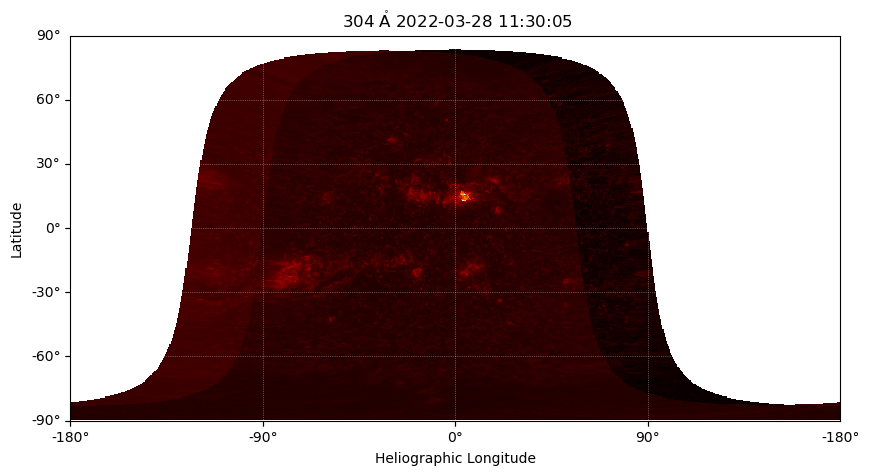

In [32]:
plt.figure(figsize=(10,5))
outmap.plot(cmap='sdoaia304', norm=m_aia.plot_settings['norm'])

#### Coordinate Dependent Weighting

As you can see this leaves a little to be desired. To reduce the obvious warping towards the points which are close to the limb in the input images, we can define a set of weights to use when co-adding the output arrays.
To reduce this warping we want to calculate an set of weights which highly weight points close to the center of the disk in the input image.

We can achieve this by using sunpy's coordinate framework. First we calculate all the world coordinates for all the pixels in all three input maps.

In [34]:
maps = [m_aia_corrected, m_stereo]

In [35]:
coordinates = tuple(map(sunpy.map.all_coordinates_from_map, maps))

To get a weighting which is high close to disk centre and low towards
the limb, we can use the Z coordinate in the heliocentric frame. This
coordinate is the distance of the sphere from the centre of the Sun
towards the observer.



In [36]:
weights = [coord.transform_to("heliocentric").z.value for coord in coordinates]

These weights are good, but they are better if the ramp down is a little
smoother, and more biased to the centre. Also we can scale them to the
range 0-1, and set any off disk (NaN) regions to 0.



In [37]:
weights = [(w / np.nanmax(w)) ** 1.5 for w in weights]
for w in weights:
    w[np.isnan(w)] = 0

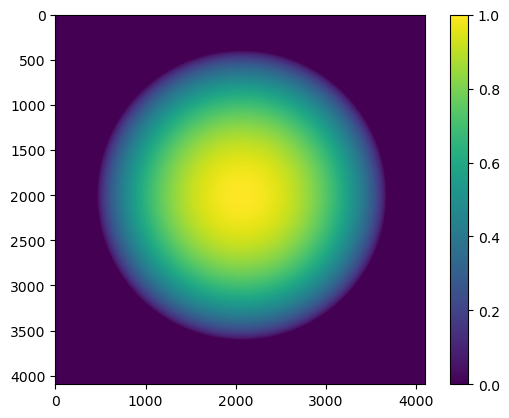

In [38]:
plt.imshow(weights[0])
plt.colorbar()

Now we can rerun the reprojection. This time we also set
``match_background=True`` which scales the images by a single scaling
factor so they are of similar brightness. We also set
``background_reference=0`` which uses the AIA map as the reference for
the background scaling.

In [39]:
array, _ = reproject_and_coadd(maps, out_wcs, shape_out,
                               input_weights=weights,
                               reproject_function=reproject_interp,
                               match_background=True,
                               background_reference=0)

Once again we create a new map from our reprojected array and new header.

In [40]:
combined_map = sunpy.map.Map(array, header)

We can plot our corrected reprojected array, this time overlaying the limb as seen from the three different observatories.
We'll also overplot the location of the flare as determined from the HEK.

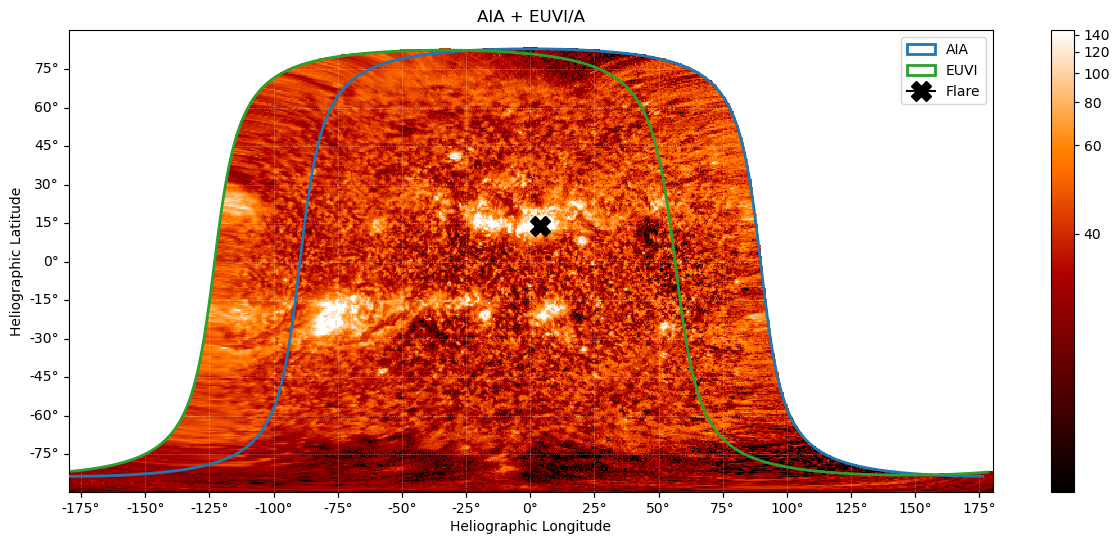

In [42]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(projection=combined_map)
im = combined_map.plot(axes=ax, cmap='sdoaia304', norm=m_aia.plot_settings['norm'],
                       clip_interval=(1,99.5)*u.percent,
                       title='AIA + EUVI/A')

# Fix the tick formatting
lon, lat = ax.coords
lon.set_coord_type("longitude")
lon.coord_wrap = 180
lon.set_format_unit(u.deg)
lat.set_coord_type("latitude")
lat.set_format_unit(u.deg)

# Fix the labeling
lon.set_axislabel('Heliographic Longitude', minpad=0.8)
lat.set_axislabel('Heliographic Latitude', minpad=0.9)
lon.set_ticks(spacing=25*u.deg, color='k')
lat.set_ticks(spacing=15*u.deg, color='k')


# Reset the view to pixel centers
_ = ax.axis((0, shape_out[1], 0, shape_out[0]))

# Draw the limb as defined by each spacecraft
m_aia.draw_limb(axes=ax, color="C0", lw=2, label='AIA')
m_stereo.draw_limb(axes=ax, color="C2", lw=2, label='EUVI')

# Plot the flare location
ax.plot_coord(flare_coords[1], marker='X', color='k', markersize=15, label='Flare')
    
# Add the legend and colorbar
plt.legend()
plt.colorbar(im, ax=ax)

You may notice that the reprojected shape of the three instruments varies in this projection.
This is because of the relative angles of the spacecraft away from the solar equator, we can inspect this using the `.observer_coordinate` property of the maps:

In [43]:
m_aia.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2022-03-28T11:30:05.150, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.01124165, -6.72365584, 1.49322527e+11)>

In [44]:
m_stereo.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2022-03-28T11:30:45.011, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-33.25158354, -7.21919964, 1.44615308e+11)>